# State-by-state Covid-19 analysis
By [Adam Marcus](https://twitter.com/marcua), with code review from [Daniel Haas](https://twitter.com/thisisdhaas) and inspiration/medical feedback from [Larry Istrail](https://twitter.com/dr_larryi)



---



The data in this analysis comes from the daily state-by-state JSON API that [The COVID Tracking Project](https://covidtracking.com) provides. You can read more about the [trustworthiness of this data](https://covidtracking.com/about-tracker/).


Each record from the API looks like this:

```
{"date":20200322,"state":"NY","positive":15168,"negative":46233, "pending":null, 
 "hospitalized":1974,"death":114,"total":61401 "dateChecked":"2020-03-22T20:00:00Z"}
```

The values are cumulative up until that date, meaning that in the example above, by March 22, NY conducted 61401 tests and saw 114 deaths.

In this analysis, we only look as positive cases/percentages. The underlying data has hospitalization/pending/death data, but we've left that to future work. **If you're an epidemiologist and have questions you'd like answered with this data, please reach out.**

In [0]:
import matplotlib
import pandas
import json
import requests
import seaborn

from datetime import datetime
from datetime import timedelta
from operator import itemgetter 

COLORS = {
    'total': 'g',
    'totalIncrease': 'g',
    'pct_total': 'g',
    'positive': 'r',
    'positiveIncrease': 'r',
    'pct_positive': 'r',
    'deaths': 'black',
    'pending': 'grey',
    'hospitalized': 'blue',
    'pct_hospitalized': 'blue',
    'hospitalizedIncrease': 'blue'}

# Pull the daily data from 
# [The COVID Tracking Project](https://covidtracking.com)'s JSON API.
response = requests.get('https://covidtracking.com/api/states/daily')
states_daily_dict = json.loads(response.text)
states_daily_df = pandas.DataFrame(states_daily_dict)

# Interpret the date properly.
states_daily_df['date'] = pandas.to_datetime(states_daily_df['date'], format='%Y%m%d')
# Fill null positives in with 0 values (This only appears to affect Alaska,
# which has no entries?)
states_daily_df['positive'] = states_daily_df['positive'].fillna(0.0)
# Rename a column so it's shorter
states_daily_df['totalIncrease'] = states_daily_df['totalTestResultsIncrease']
# Add some percentages to study growth. Fill with 0.0's if we divided by 0.
states_daily_df['pct_positive'] = (
    states_daily_df['positive'] / states_daily_df['total']).fillna(0.0)
states_daily_df['pct_hospitalized'] = (
    states_daily_df['hospitalized'] / states_daily_df['total']).fillna(0.0)    
# Don't mock for creating 1.0s, please :).
states_daily_df['pct_total'] = (
    states_daily_df['total'] / states_daily_df['total']).fillna(0.0)  


In [0]:
def plot_state_testing_over_time(
    states_daily_df=None,
    title=None,
    sort_field=None,
    sharex=None,
    first_measure=None,
    total_measure=None):
  """
  Plots `states_daily_df` in a grid by faceting on each state. Each state chart
  has the date on the y axis and overlapping bars for `first_measure` and
  `total_measure` cases on the x axis.
   * `title` is the title of the plot
   * `sort_field` is the field on which to order the states.
   * `sharex` is a boolean that dictates whether to use the same x axis across
     all charts. States have drastically different total/positive counts, so
     sharing/not sharing axes allows for different comparisons.
  """
  # Sort states by the most recent day's entry.
  states_recent_daily_df = states_daily_df[
      states_daily_df['date'] >= (datetime.now() - timedelta(days=2))]
  states_ordered_by_sort_field = [
      record['state'] for record in
      sorted(states_recent_daily_df.to_dict('records'),
             key=itemgetter(sort_field),
             reverse=True)]

  # Create the chart
  seaborn.set(style='darkgrid')
  seaborn.set_color_codes(palette='dark')
  facet = seaborn.FacetGrid(
      states_daily_df,
      col='state',
      col_wrap=5,
      col_order=states_ordered_by_sort_field,
      sharex=sharex,
      legend_out=False
      )
  (facet
    .map(matplotlib.pyplot.barh, 'date', total_measure, color=COLORS[total_measure])
    .map(matplotlib.pyplot.barh, 'date', first_measure, color=COLORS[first_measure])
    .set_axis_labels('', 'Date')
  )

  # Add a title/legend
  facet.fig.suptitle(title)
  matplotlib.pyplot.subplots_adjust(top=0.95)
  facet.fig.get_axes()[0].legend(
      handles=[
          matplotlib.patches.Patch(color=color, label=label)
          for label, color in COLORS.items()
          if label in [first_measure, total_measure]],
      loc='lower right')
  matplotlib.pyplot.show()

# Positive cases, different x axes
NY leads the pack by far in terms of new positive cases. Until March 21, WA had the second-highest positive count, but was replaced by NJ on March 22. NJ has less than 10x the tests that NY does, and a large fraction of its total tests are coming back positive. Later on, we'll see more reason for concern in NJ.

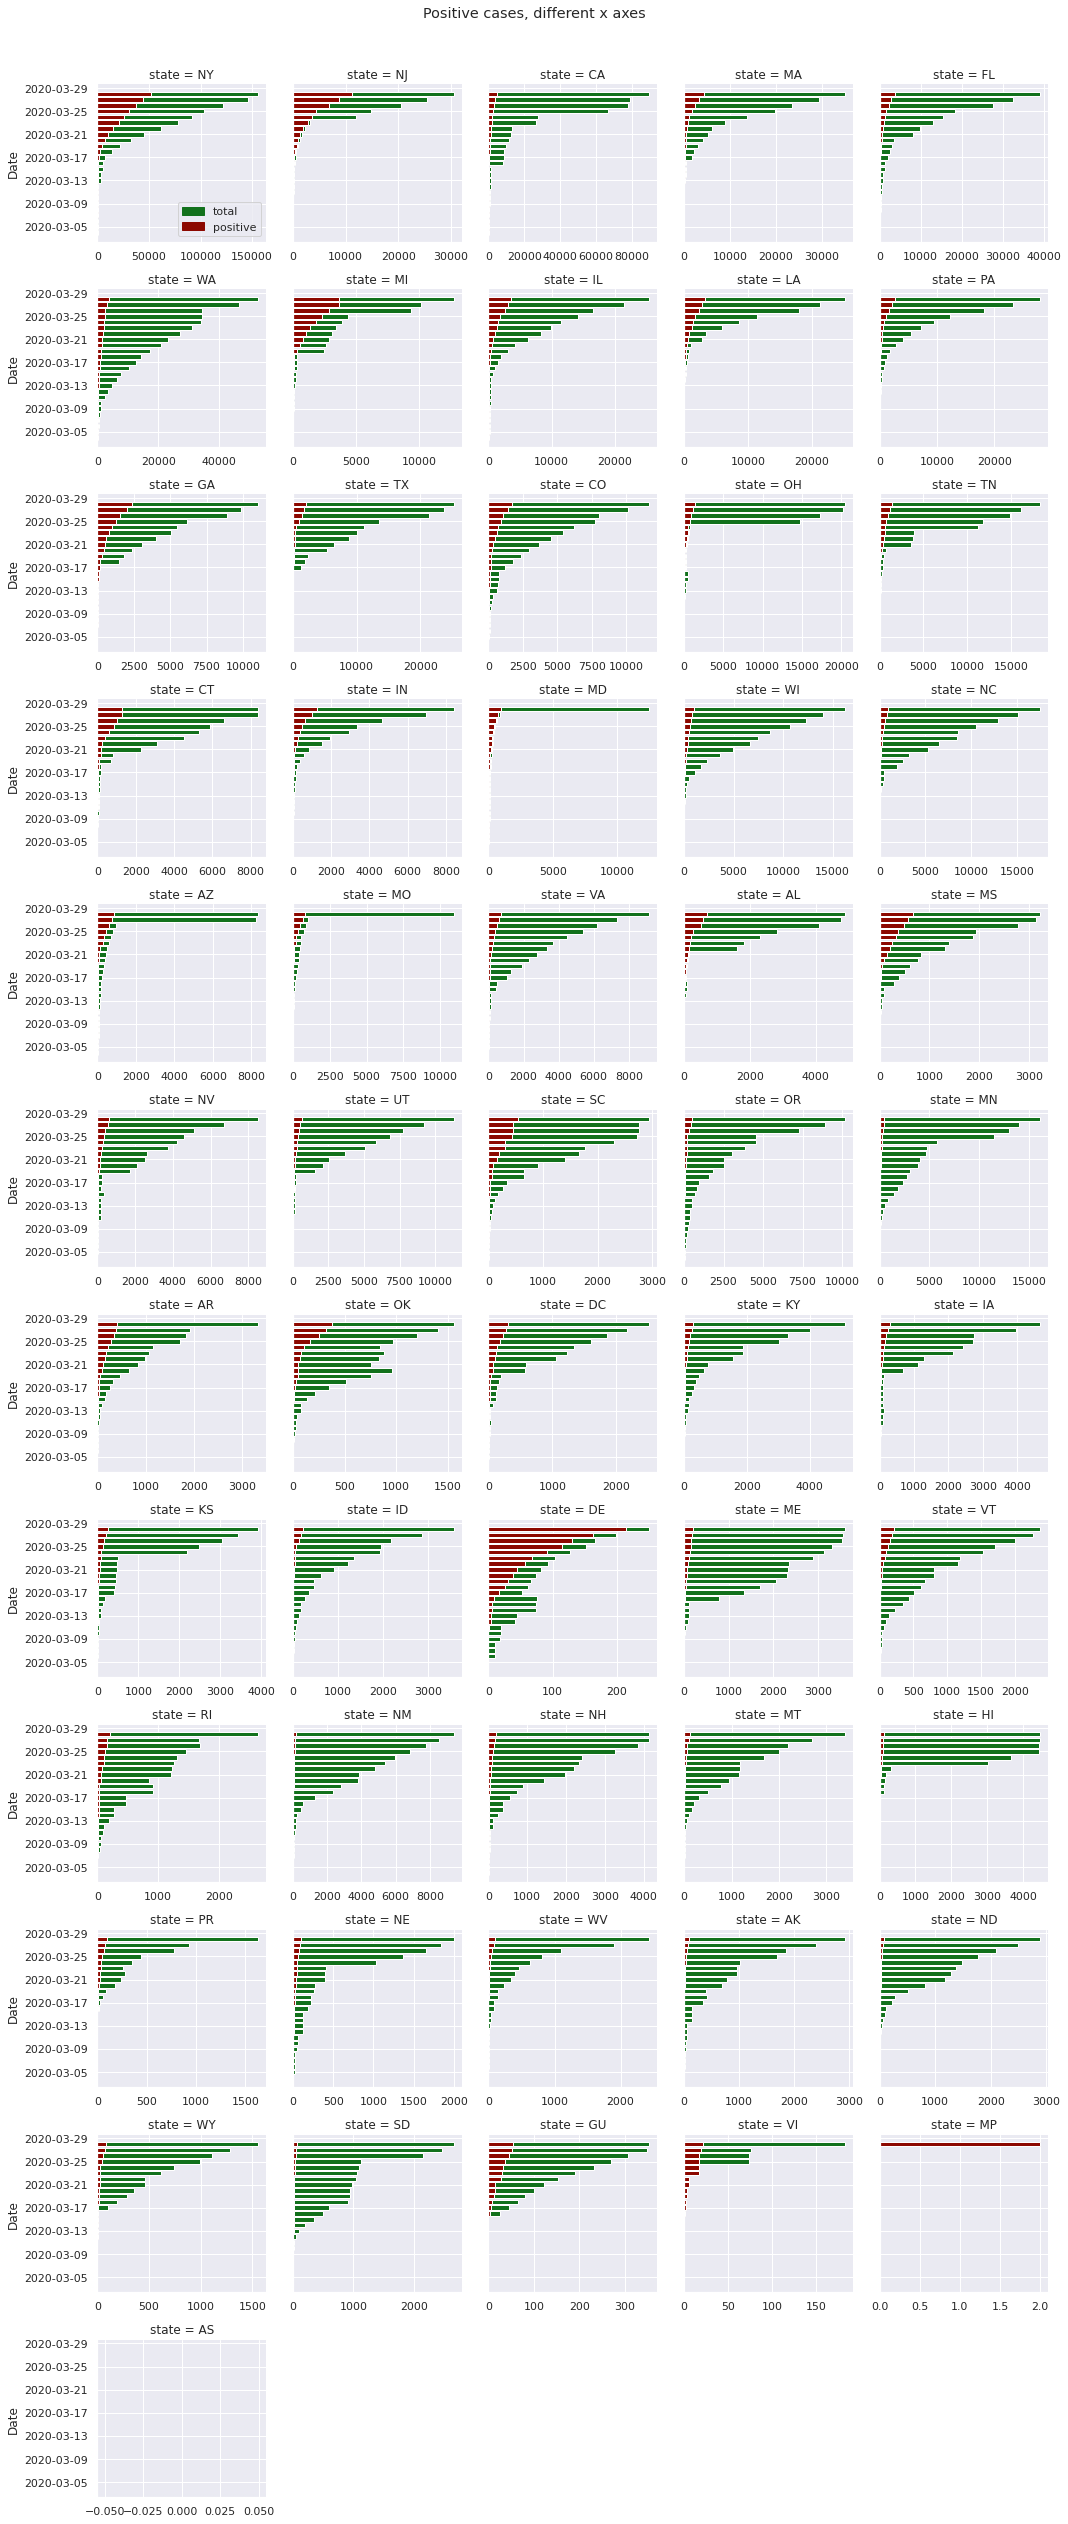

In [48]:
plot_state_testing_over_time(
    states_daily_df=states_daily_df,
    title='Positive cases, different x axes',
    sort_field='positive',
    sharex=False,
    first_measure='positive',
    total_measure='total')

# Positive cases, sharing x axes
When the charts all share the same x axis, you can see the difference in sheer quantity of tests across the states. Of the top 10 positive states, NY/WA/CA/IL/FL/MA stand out as having large testing efforts. For a state with a relatively high population and number of positives like NJ, the number of tests do not seem adequate.

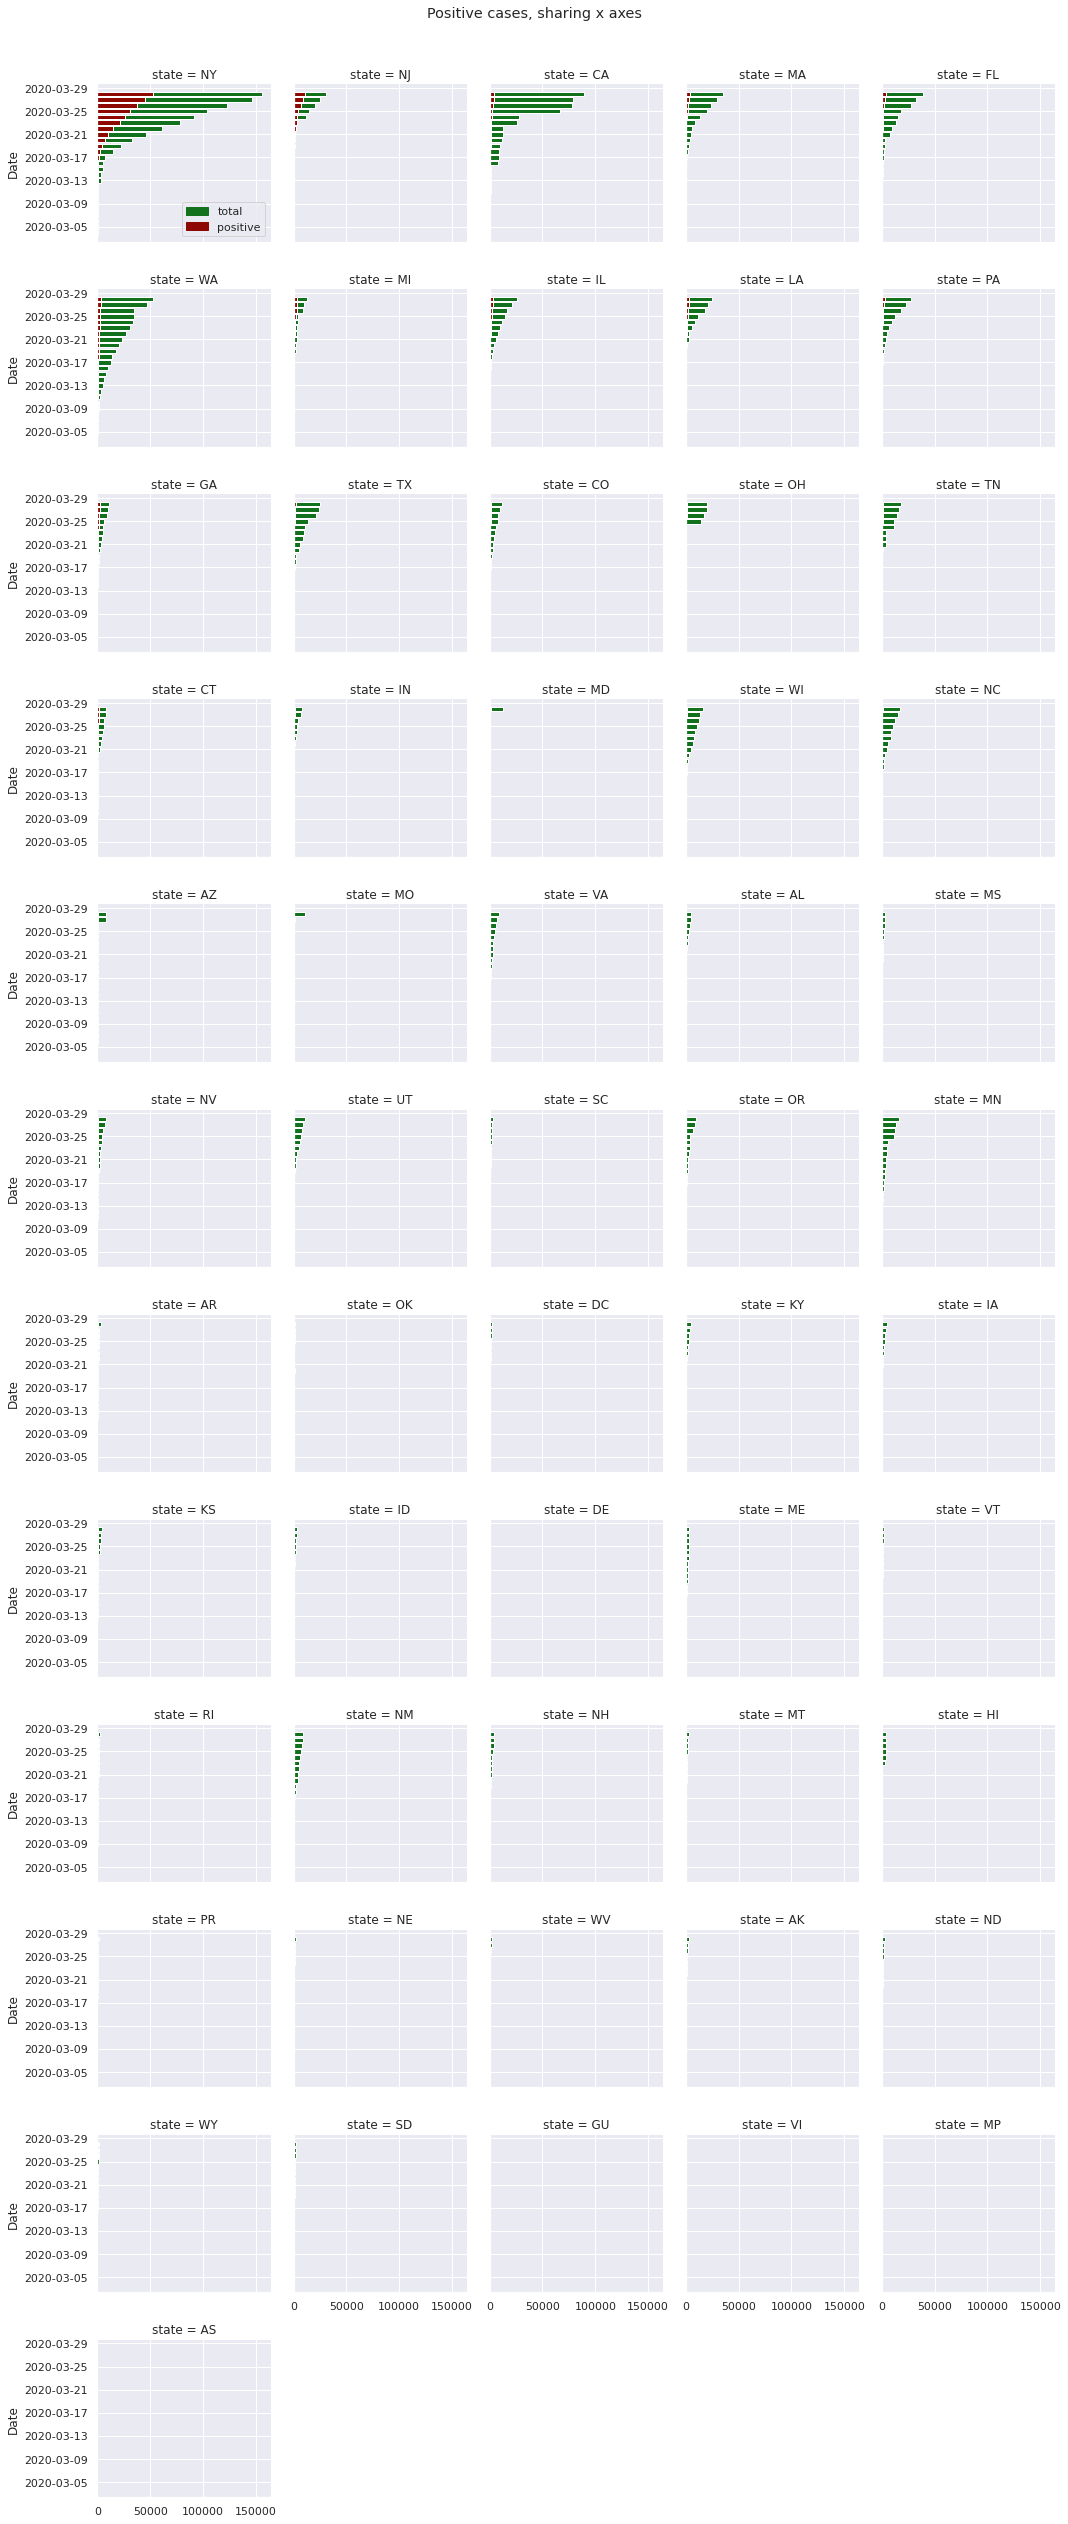

In [49]:
plot_state_testing_over_time(
    states_daily_df=states_daily_df,
    title='Positive cases, sharing x axes',
    sort_field='positive',
    sharex=True,
    first_measure='positive',
    total_measure='total')

# Percentage of positive cases
Since the number of tests per day is increasing in most states, you'd expect the number of positive cases to increase. How can you tell what states are seeing a growth in cases? In this chart, we plot the percentage of positive cases per day in each state. Some notable observations:
* New Jersey, despite having the second-highest positive case count in the nation and significantly less testing than New York, has a large and growing fraction of positive results. 
* More broadly, NJ/MD/OH/DE look like they are on a bad trajectory.
* NY, despite having a large number of positive cases and testing, does not seem to be increasing in the percentage of positive cases.
* WA, which is third in the nation in number of positive cases (down from second as of March 22), is seeing a decrease in the percentage of positive cases.

Note: Don't trust these numbers too much. So much of the fraction of positive cases depends on the sampling methodology. What we really need to understand the spread is random sampling of the population, which is understandably hard given the US is just finally ramping up testing.

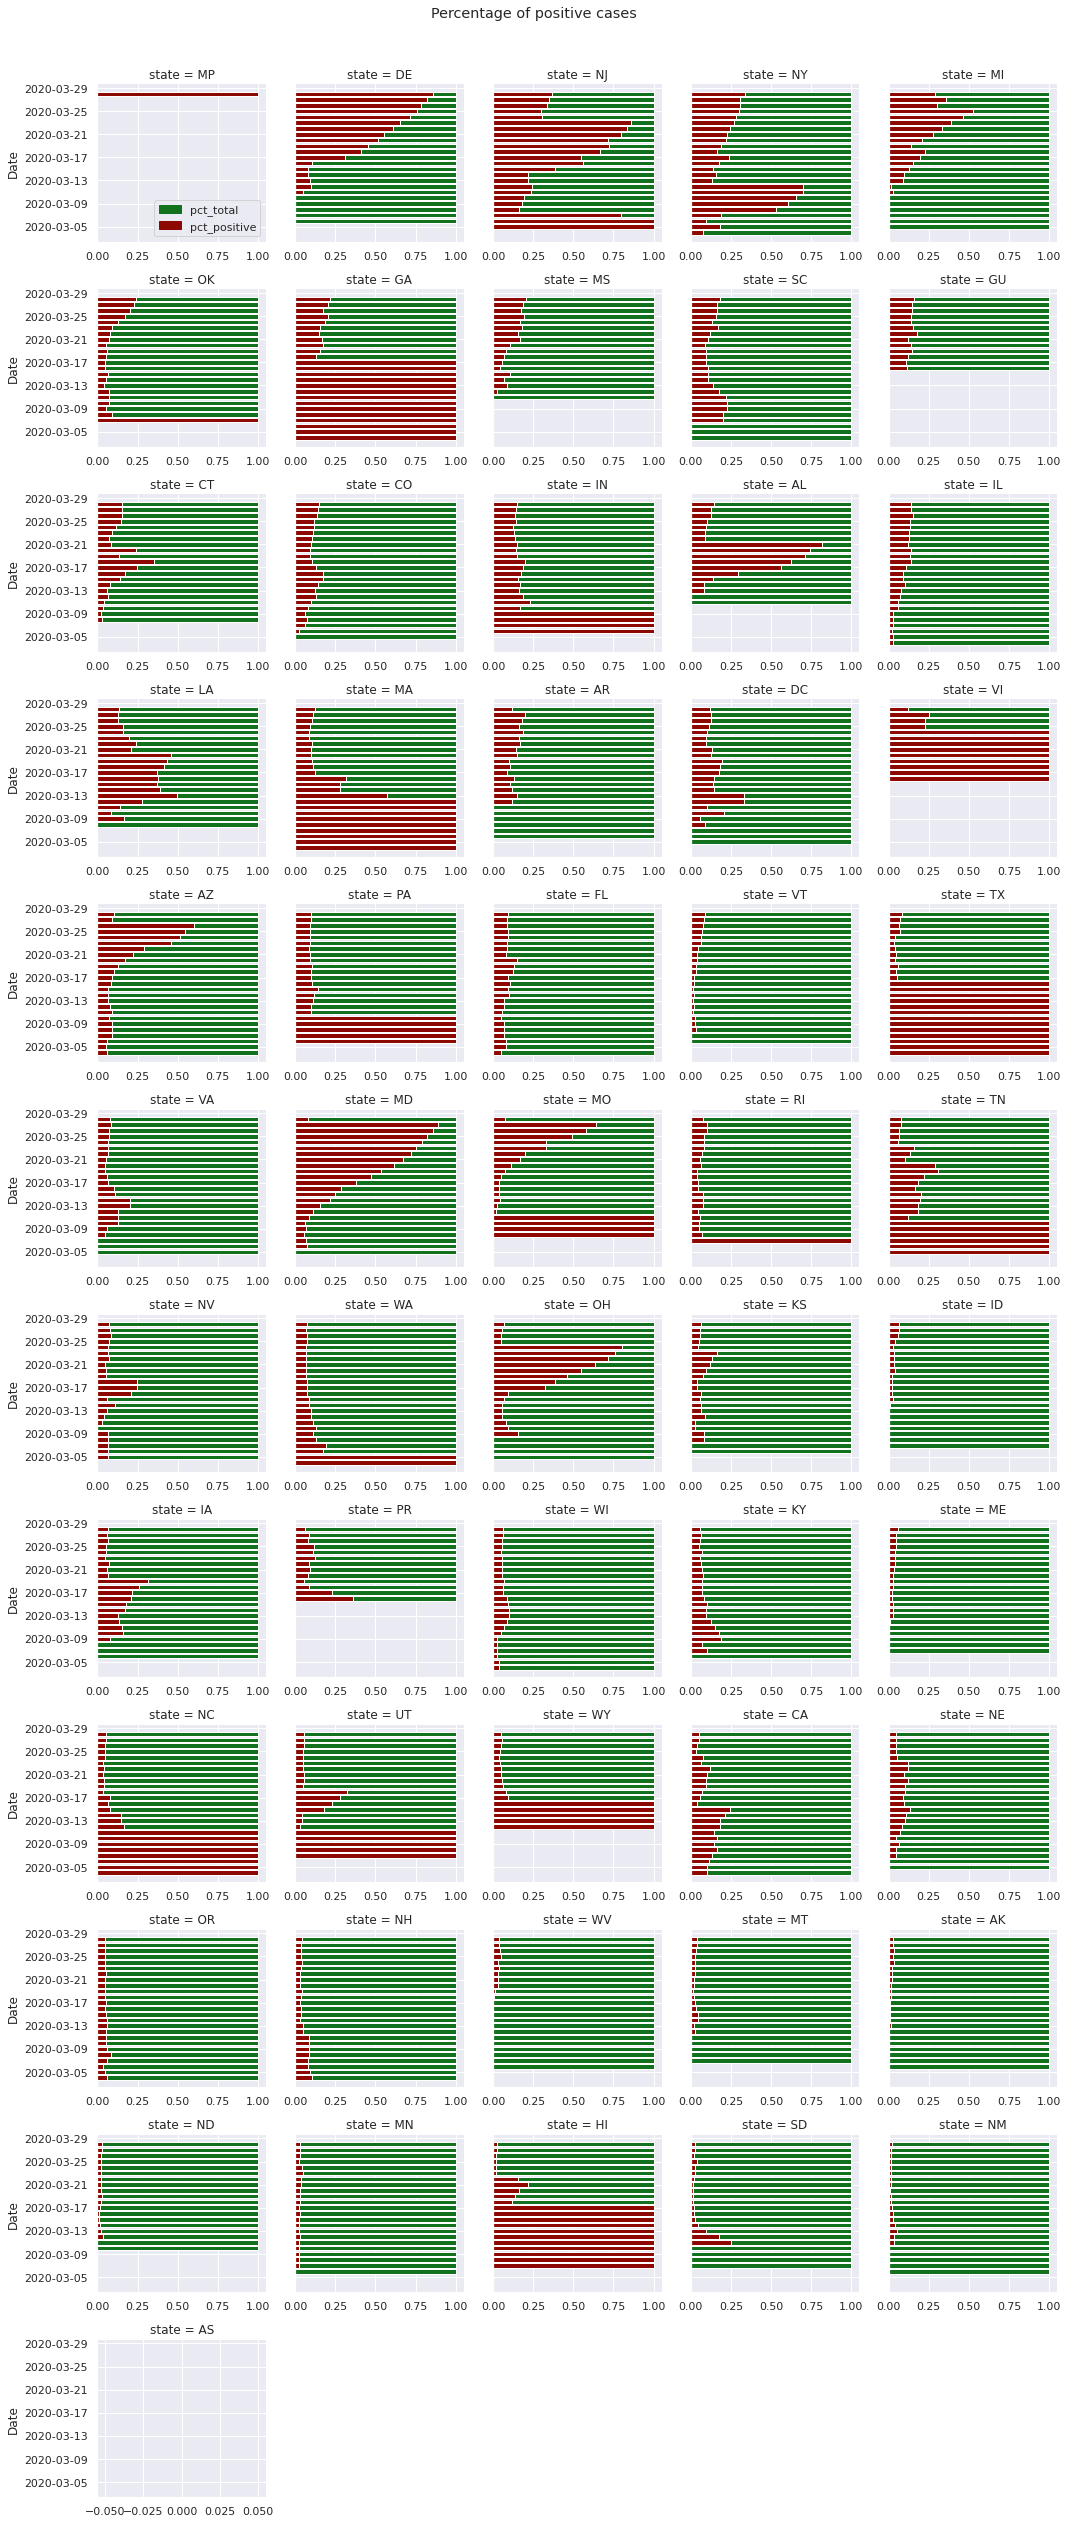

In [50]:
plot_state_testing_over_time(
    states_daily_df=states_daily_df,
    title='Percentage of positive cases',
    sort_field='pct_positive',
    sharex=False,
    first_measure='pct_positive',
    total_measure='pct_total')

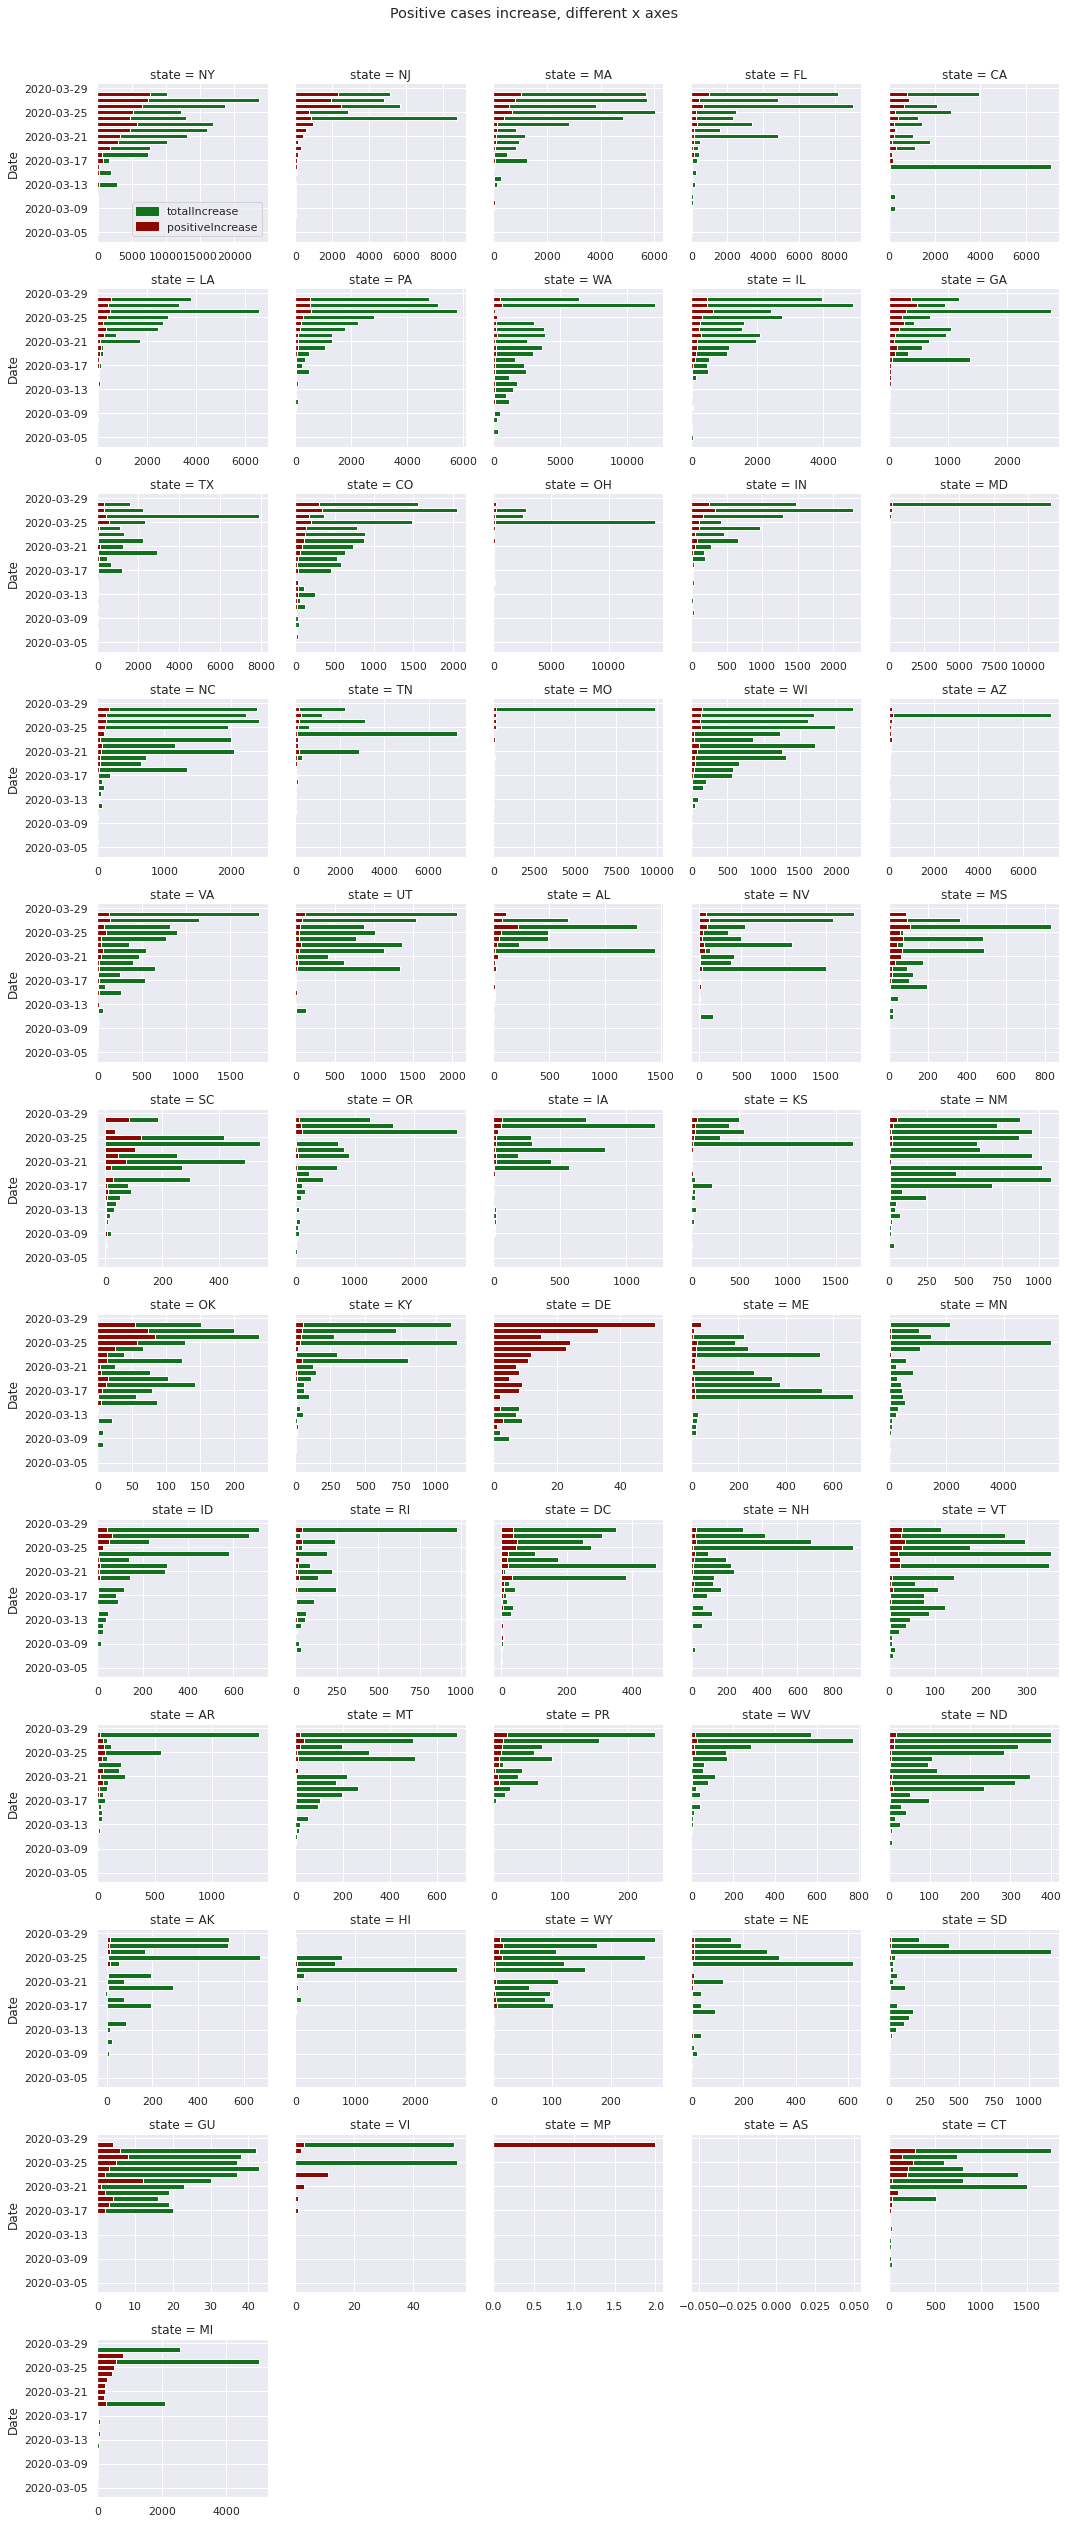

In [51]:
plot_state_testing_over_time(
    states_daily_df=states_daily_df,
    title='Positive cases increase, different x axes',
    sort_field='positiveIncrease',
    sharex=False,
    first_measure='positiveIncrease',
    total_measure='totalIncrease')

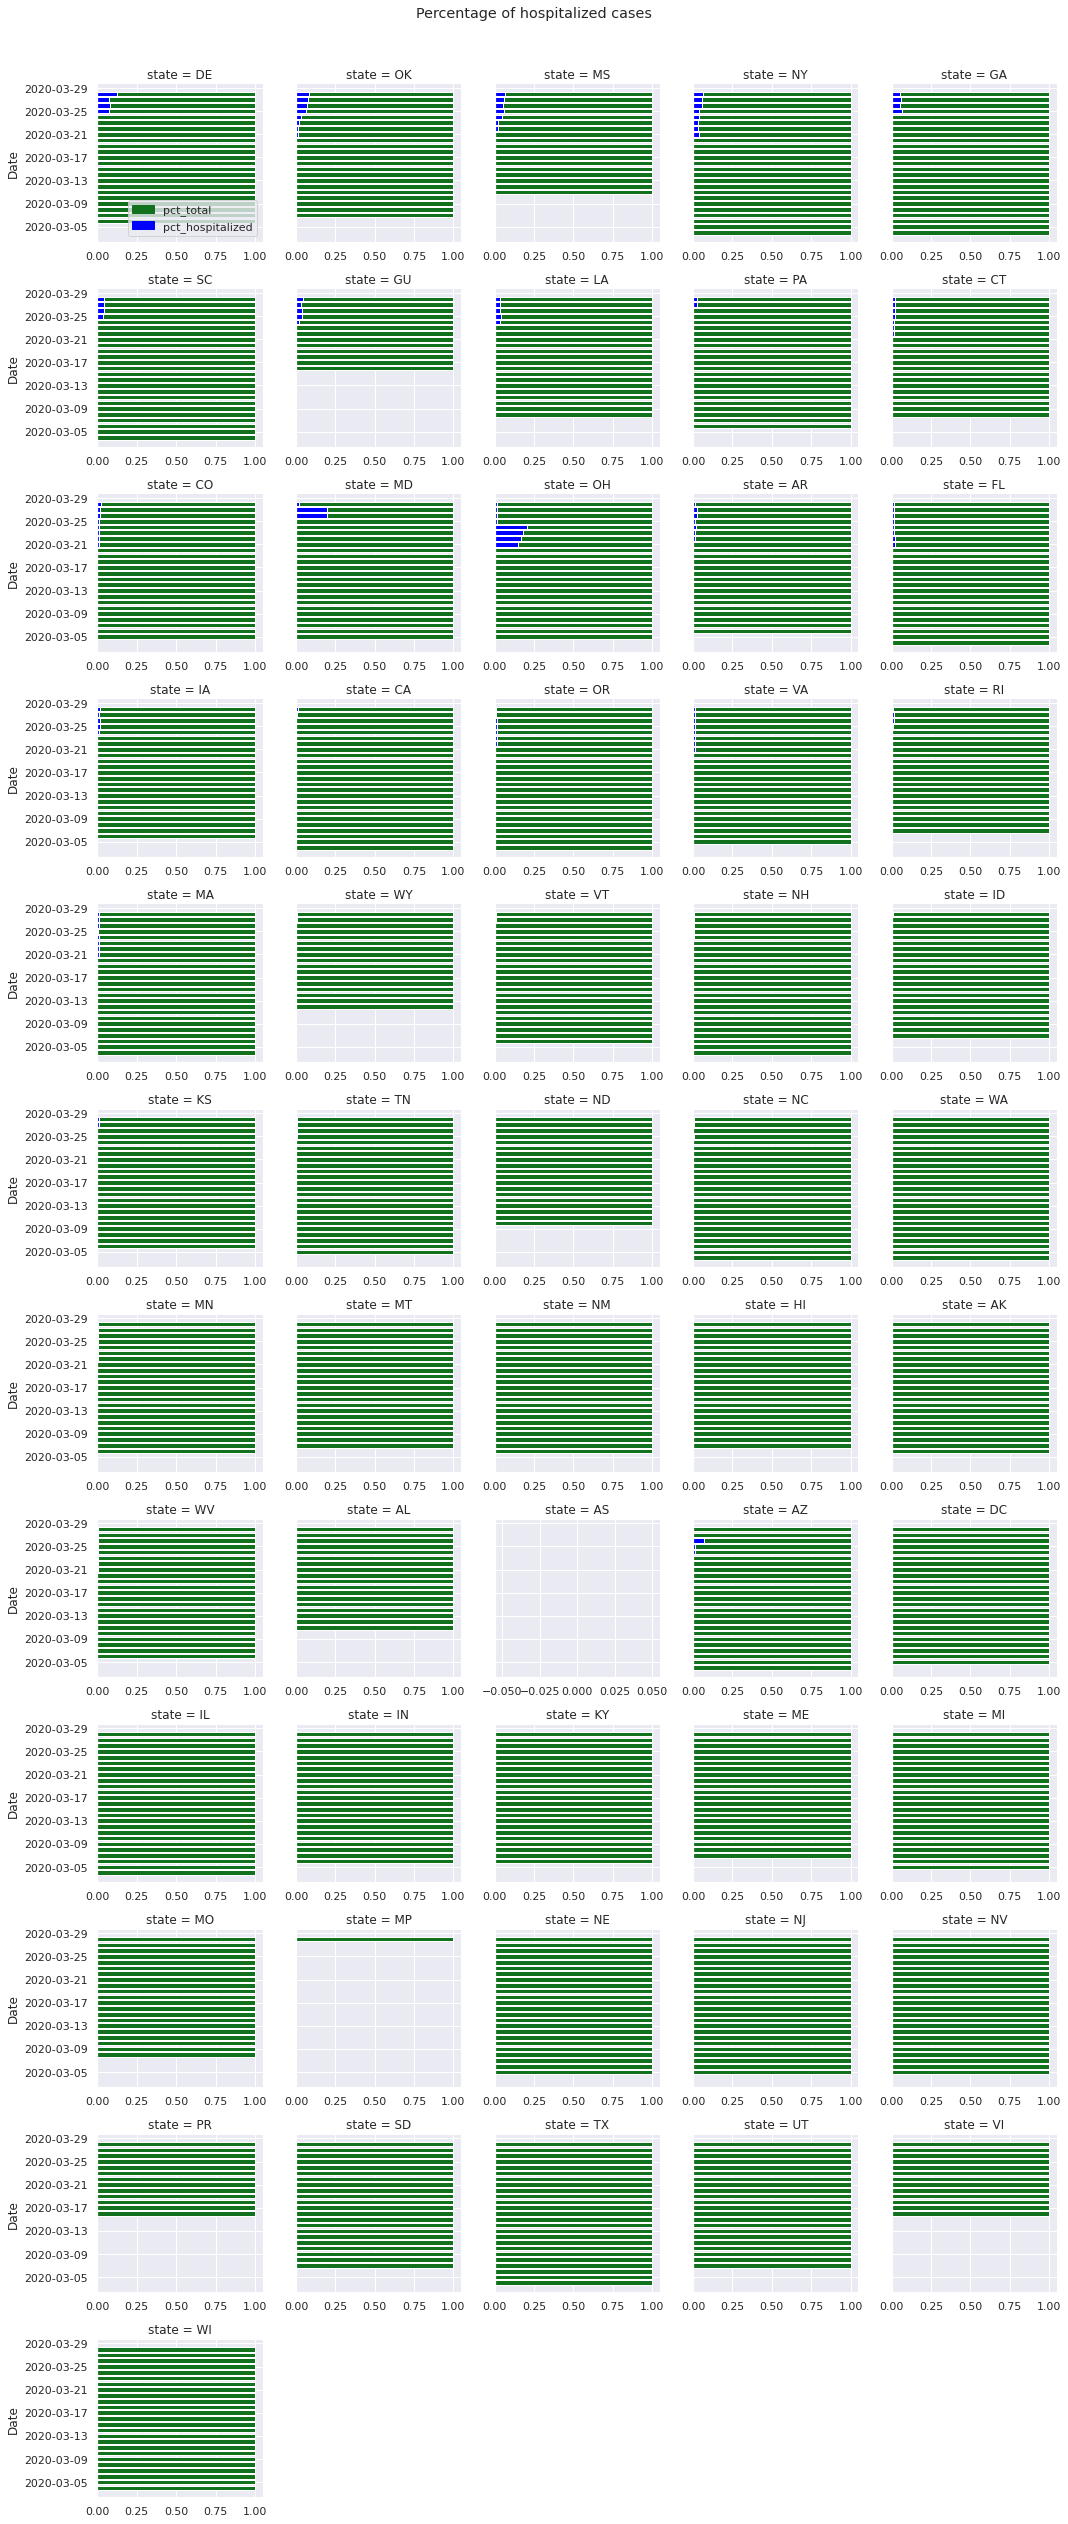

In [52]:
plot_state_testing_over_time(
    states_daily_df=states_daily_df,
    title='Percentage of hospitalized cases',
    sort_field='pct_hospitalized',
    sharex=False,
    first_measure='pct_hospitalized',
    total_measure='pct_total')